# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

# Instrucciones del proyecto

1. Descarga y prepara los datos.Explica el procedimiento.
2. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. - Describe brevemente tus hallazgos.
3. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.
4. Realiza la prueba final.

# Descripción de los datos

Puedes encontrar los datos en el archivo  /datasets/Churn.csv file. Descarga el conjunto de datos.

## Características

- RowNumber: índice de cadena de datos
- CustomerId: identificador de cliente único
- Surname: apellido
- CreditScore: valor de crédito
- Geography: país de residencia
- Gender: sexo
- Age: edad
- Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- Balance: saldo de la cuenta
- NumOfProducts: número de productos bancarios utilizados por el cliente
- IsActiveMember: actividad del cliente (1 - sí; 0 - no)
- HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- EstimatedSalary: salario estimado

## Objetivo

- Exited: El cliente se ha ido (1 - sí; 0 - no)

## Librerías

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from pprint import pprint
from scipy.stats import randint
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score
)
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import re

## Carga de datos

In [49]:
data=pd.read_csv('datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [51]:
#Funcion para pasar columnas al formato snake_case
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [52]:
#Pasamos las columnas al modo snake_case
columns=data.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
data.columns=new_cols
print(data.columns)

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


In [53]:
data.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [54]:
#Cambiamos el tipo de dato a string
data['row_number']=data['row_number'].astype(str)
data['customer_id']=data['customer_id'].astype(str)
data['balance']=data['balance'].astype(int)
data['estimated_salary']=data['estimated_salary'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  object 
 1   customer_id       10000 non-null  object 
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  int32  
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  int32  
 13  exited            10000 non-null  int64  
dtypes: float64(1), int32(2), int64(6), object(5)
memory usage: 1015.8+ KB


Podemos ver a simple vista con el data info, que nuestros datos están bien, y que solo tenemos ausentes en la columna 'tenure', sin embargo, veremos más a fondo los ausetes y los duplicados.

En cuanto a los tipos de datos vemos que las columnas 'RowNumber' y 'CustomerId' deberían ser tipo string para no cometer errores con estos números que no son significativos, sin embargo, debido a que el objetivo del proyecto es predecir los clientes que se van del banco, las tres primeras columnas no son relevantes para entrenar el modelo, por lo que no se tendrán en cuenta.

## Limpieza de datos

In [55]:
#Calculamos los ausentes
print('Ausentes: \n',data.isna().sum())

Ausentes: 
 row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64


In [56]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',100*data.isna().sum()/data.shape[0])

Porcentaje de significancia: 
 row_number          0.00
customer_id         0.00
surname             0.00
credit_score        0.00
geography           0.00
gender              0.00
age                 0.00
tenure              9.09
balance             0.00
num_of_products     0.00
has_cr_card         0.00
is_active_member    0.00
estimated_salary    0.00
exited              0.00
dtype: float64


Podeos ver que solo tenure tiene 909 ausentes el cual equivale al 9.09% de los datos, podemos trabajar con estos para imputarlos.

In [57]:
data[data['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0,3,1,0,140469,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391,1,0,1,90878,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050,2,0,0,86424,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561,1,0,0,164040,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857,1,0,0,84509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409,2,1,1,138361,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216,1,1,0,117369,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593,2,0,0,113308,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841,2,1,0,96833,0


In [58]:
#Llenamos los ausentes con la mediana
data['tenure'].fillna(data['tenure'].median(),inplace=True)
print(100*data.isna().sum()/data.shape[0])


row_number          0.0
customer_id         0.0
surname             0.0
credit_score        0.0
geography           0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
num_of_products     0.0
has_cr_card         0.0
is_active_member    0.0
estimated_salary    0.0
exited              0.0
dtype: float64


Llenamos los datos ausentes con la mediana.

In [59]:
print('Duplicados: \n',data.duplicated().sum())

Duplicados: 
 0


No tenemos duplicados, y rellenamos los ausentes, por lo cual estamos listos para comenzar el modelo de clasificación.

## Entrenamiento

### Examinamos el balanceo

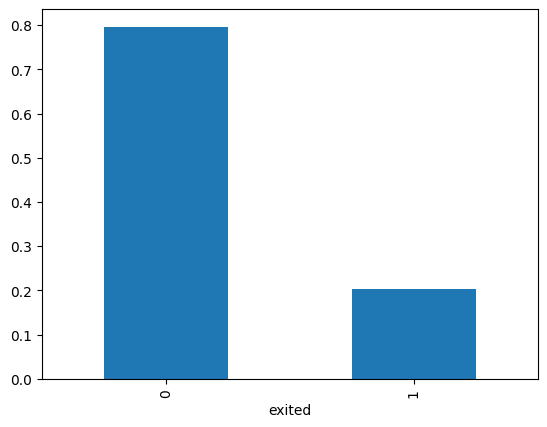

In [60]:
#Gráficamos las frecuencias relativas de cada clase
balance=data['exited'].value_counts(normalize=True)
plt=balance.plot(kind='bar')

Podemos ver que la clase "0" es predominante con un porcentaje aproximado del 80%, en cambio la clase "1" tiene solo el 20%

### Separamos el dataframe en entrenamiento y testeo

In [61]:
seed=12345
data_model=data.drop(['customer_id','row_number','surname'],axis=1)
df_train,df_test=train_test_split(data_model,random_state=seed,test_size=0.2)

### Separamos el dataset en entrenamiento y validación

In [62]:
#Separamos los datos 
features= df_train.drop(['exited'],axis=1)
target=df_train['exited']

features_train, features_valid, target_train, target_valid=train_test_split(
    features,target,random_state=seed,test_size=0.25)

### Escalado de caracteristicas

In [63]:
#Vamos a escalar las características para que nuestro modelo pueda tomar estas variables
numeric=['credit_score','age','tenure','balance','num_of_products','has_cr_card','is_active_member','estimated_salary']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
scaler.fit(features_valid[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])

### Codificación de las variables categoricas para los arboles

Vamos a codificar con etiquetas el dataframe para los arboles y utilizaremos ONE-HOT para la regresion logística.

In [64]:
features_train=pd.get_dummies(features_train,drop_first=True)
features_valid=pd.get_dummies(features_valid,drop_first=True)
model=RandomForestClassifier(random_state=seed)

### Random Forest

In [65]:
#Ahora vamos a pasar la lista de parametros que queremos iterar:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de features a considerar para cada separación
max_features = randint(1, 11)
# Máximo número de niveles a considerar en el arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número mínimo  de pruebas requeridas para las eparación de un nodo
min_samples_split = [2, 5, 10]
# Número minimo de pruebas requeridas para cada nodo hoja
min_samples_leaf = [1, 2, 4]
# Metodo de selección de pruebas para el entrenamiento de cada árbol
bootstrap = [True, False]
# Creación de la malla aleatoria
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000294E839AB70>,
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [66]:
#Ahora junto con la malla y el RandomizedCV vamos a generar el mejor modelo con los mejores hiperparametros 
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Entrenamos el modelo
model_random.fit(features_train,target_train)
print(model_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': True, 'max_depth': 60, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1600}


In [67]:
#Medimos la exactitud de nuestro modelo 
best_random = model_random.best_estimator_
random_prediction = best_random.predict(features_valid)
random_accuracy=metrics.accuracy_score(target_valid,random_prediction)
recall_rf=metrics.recall_score(target_valid,random_prediction)
f1_rf=metrics.f1_score(target_valid,random_prediction)
roc_auc_rf=roc_auc_score(target_valid,random_prediction)
print("Accuracy:",random_accuracy)
print('ROC-AUC: ',roc_auc_rf)
print('Recall: ',recall_rf,'\nF1-score: ',f1_rf)

Accuracy: 0.8605
ROC-AUC:  0.7003357075529432
Recall:  0.4373401534526854 
F1-score:  0.5507246376811594


Tenemos una buena exactitud aunque con datos desbalanceados, por lo que debemos balancearlos. Por otro lado, el area bajo la curva ROC nos indica que el modelo no es malo pero puede mejorar.

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1609
           1       0.74      0.44      0.55       391

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.85      0.86      0.85      2000



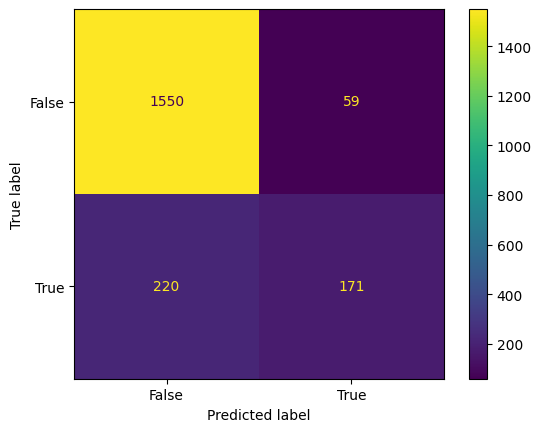

In [68]:
#Mostramos la matriz de confusión y el reporte con nuestras métricas de clasificación
print(classification_report(target_valid,random_prediction))
confusion_matrix = metrics.confusion_matrix(target_valid,random_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()


Podemos ver en la matriz que los datos están desbalanceados, debido a que el recall de la clase 1 es de 0.44 y el f1 es 0.55 lo que indica que del total de la suma de verdaderos positivos y falsos negativos, solo se está acertanco al 44% de los datos con categoría 1, por lo cual debemos hacer labores de balanceo para mejorar este resultado.

### Decision Tree

In [69]:
#Parametros del arbol de decisión
params = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
tree=DecisionTreeClassifier(random_state=seed) 

In [70]:
#Iteramos para hallar los mejores hiperparametros para el arbol de decisión
random_tree=RandomizedSearchCV(estimator = tree, param_distributions = params, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Entrenamos el modelo
random_tree.fit(features_train,target_train)
print(random_tree.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 2}


In [71]:
#Medimos la exactitud del modelo
best_tree = random_tree.best_estimator_
tree_prediction = best_tree.predict(features_valid)
tree_accuracy=metrics.accuracy_score(target_valid,tree_prediction)
roc_auc_dt=roc_auc_score(target_valid,tree_prediction)
print("Accuracy:",tree_accuracy)
print('ROC-AUC: ',roc_auc_dt)
recall_dt=metrics.recall_score(target_valid,tree_prediction)
f1_dt=metrics.f1_score(target_valid,tree_prediction)
print('Recall: ',recall_dt,'\nF1-score: ',f1_dt)


Accuracy: 0.8425
ROC-AUC:  0.6291313726020037
Recall:  0.27877237851662406 
F1-score:  0.40900562851782374


Tenemos una buena exactitud aunque con datos desbalanceados al igual que el Random Forest, por lo que debemos balancearlos. Por otro lado, el area bajo la curva ROC da 0.62, lo que nos indica que el modelo no es malo pero puede mejorar.

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1609
           1       0.77      0.28      0.41       391

    accuracy                           0.84      2000
   macro avg       0.81      0.63      0.66      2000
weighted avg       0.83      0.84      0.81      2000



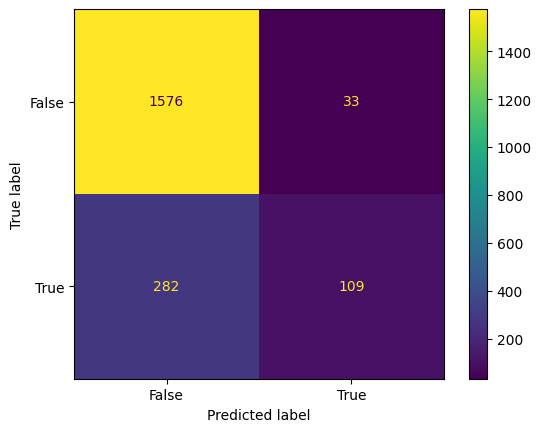

In [72]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_valid,tree_prediction))
confusion_matrix = metrics.confusion_matrix(target_valid,tree_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Al igual que el bosque aleatorio, podemos ver que el desbalanceo afecta el recall y el f1 score de la clase 1, con valores de 0.28 y 0.41 respectivamente, incluso en este caso la precisión se vio afectada al bajar a un 62%. También debemos trabajar con estos datos para contraarrestar el balanceo.

### Logistic Regression

In [73]:
#Parametros de iteración de la regresión logística
params={
    'max_iter': range(100, 500),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear'],
    'warm_start' : [True, False],
    'C': np.arange(0.01, 1, 0.01)
}
log_reg=LogisticRegression(random_state=seed)

In [74]:
#Entrenamos el modelo
log_random=RandomizedSearchCV(estimator=log_reg,param_distributions=params,n_iter=100,cv = 3, verbose=2, random_state=seed, n_jobs = -1)
log_random.fit(features_train,target_train)
print(log_random.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'warm_start': False, 'solver': 'lbfgs', 'max_iter': 285, 'C': 0.02}


In [75]:
#Medimos la exactitud del modelo
best_log = log_random.best_estimator_
log_prediction = best_log.predict(features_valid)
log_accuracy=metrics.accuracy_score(target_valid,log_prediction)
roc_auc_lr=roc_auc_score(target_valid,log_prediction)
print("Accuracy:",log_accuracy)
print('ROC-AUC: ',roc_auc_lr)
recall_lr=metrics.recall_score(target_valid,log_prediction)
f1_lr=metrics.f1_score(target_valid,log_prediction)
print('Recall: ',recall_lr,'\nF1-score: ',f1_lr)

Accuracy: 0.8155
ROC-AUC:  0.5726619288242765
Recall:  0.17391304347826086 
F1-score:  0.26930693069306927


La exactitud de este modelo es la más baja de los tres modelos, al igual que el área bajo la curva, sin embargo, podemos mejorar este valor.

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1609
           1       0.60      0.17      0.27       391

    accuracy                           0.82      2000
   macro avg       0.71      0.57      0.58      2000
weighted avg       0.78      0.82      0.77      2000



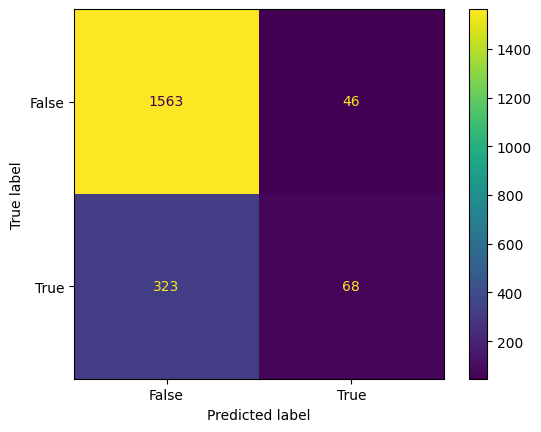

In [76]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_valid,log_prediction))
confusion_matrix = metrics.confusion_matrix(target_valid,log_prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Al análizar los resultados de la regresión logística, podemos ver que también es afectada por el desbalanceo, al tener un recall para la clase 1 de 0.17 y un recall de 0.27, lo que indica que tenemos que trabajar con el desbalanceo para lograr subir estas métricas.

## Mejora del modelo

### Sobremuestreo

In [77]:
#Definimos la función para arreglar el sobremuestreo
def upsample(features, target, repeat):
    #Primero dividimos el conjunto de datos de entrenamiento en positivos y negativos 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    #Posteriormente multiplicamos los datos de la clase que tiene menos datos, en este caso la clase 1 y unimos todos los datos
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #Por último, mesclamos todos los datos con la función shuffle y devolvemos los datos desbalanceados
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=seed
    )

    return features_upsampled, target_upsampled

In [78]:
features_upsampled_train, target_upsampled_train = upsample(
    features_train, target_train, 3
)
features_upsampled_valid, target_upsampled_valid = upsample(
    features_valid, target_valid, 3
)

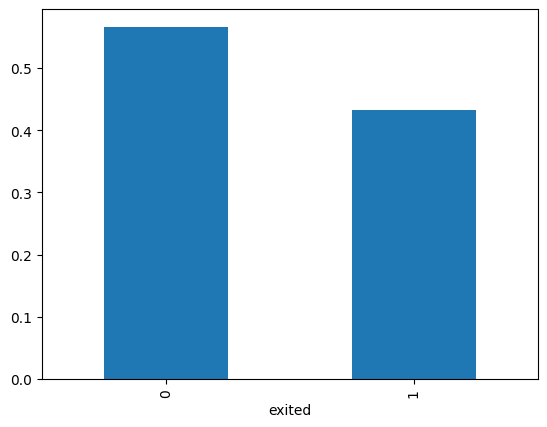

In [79]:
#Gráficamos las frecuencias relativas de cada clase
balance=target_upsampled_train.value_counts(normalize=True)
plt=balance.plot(kind='bar')

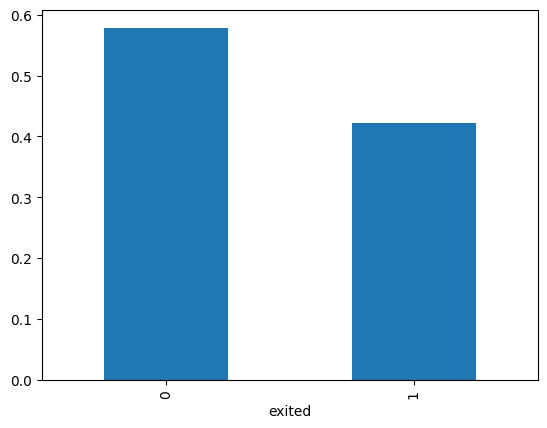

In [80]:
balance=target_upsampled_valid.value_counts(normalize=True)
plt=balance.plot(kind='bar')

### Random Forest con sobremuestreo

In [81]:
# Entrenamos el modelo de nuevo con sobremuestreo
model_random.fit(features_upsampled_train,target_upsampled_train)
print(model_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': False, 'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1800}


In [82]:
#Medimos la exactitud de nuestro modelo 
best_random = model_random.best_estimator_
random_prediction_balanced = best_random.predict(features_upsampled_valid)
random_accuracy_balanced=metrics.accuracy_score(target_upsampled_valid,random_prediction_balanced)
roc_auc_rfb=roc_auc_score(target_upsampled_valid,random_prediction_balanced)
print("Accuracy:",random_accuracy_balanced)
print('ROC-AUC: ',roc_auc_rfb)
print('Diferencia accuracy: ',random_accuracy_balanced-random_accuracy)
print('Diferencia ROC-AUC: ',roc_auc_rfb-roc_auc_rf)
recall_rfb=metrics.recall_score(target_upsampled_valid,random_prediction_balanced)
f1_rfb=metrics.f1_score(target_upsampled_valid,random_prediction_balanced)
print('Recall: ',recall_rfb,'\nF1-score: ',f1_rfb)
print('Diferencia Recall: ',recall_rfb-recall_rf)
print('Diferencia F1: ',f1_rfb-f1_rf)


Accuracy: 0.7437095614665709
ROC-AUC:  0.7042793175853854
Diferencia accuracy:  -0.11679043853342919
Diferencia ROC-AUC:  0.003943610032442257
Recall:  0.45268542199488493 
F1-score:  0.5983098591549296
Diferencia Recall:  0.01534526854219953
Diferencia F1:  0.0475852214737702


Podemos ver que al sobreajustar los datos se disminuye la exactitud en un 11% sin embargo, la calidad del modelo aumento en un 0.3% como lo vemos en la métrica ROC-AUC.

              precision    recall  f1-score   support

           0       0.71      0.96      0.81      1609
           1       0.88      0.45      0.60      1173

    accuracy                           0.74      2782
   macro avg       0.79      0.70      0.71      2782
weighted avg       0.78      0.74      0.72      2782



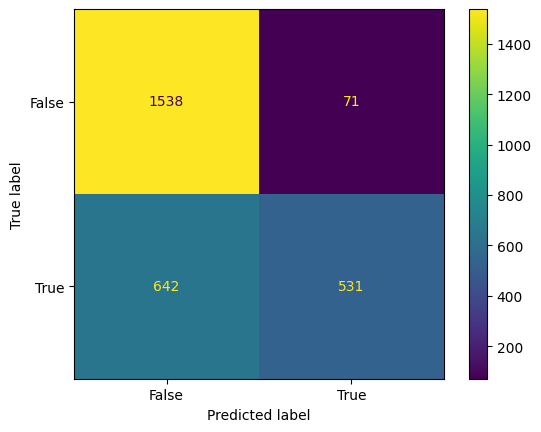

In [83]:
#Mostramos la matriz de confusión y el reporte con nuestras métricas de clasificación
print(classification_report(target_upsampled_valid,random_prediction_balanced))
confusion_matrix = metrics.confusion_matrix(target_upsampled_valid,random_prediction_balanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Podemos ver que al triplicar los datos de la clase uno, nuestro dataset se balanceo y obtuvimos un mejor recall y f1 score sobre esa clase, obteniendo 0.45 y 0.60 respectivamente, sacrificando la exactitud que ahora es del 74%. 

### Decision Tree con sobremuestreo

In [84]:
random_tree.fit(features_upsampled_train,target_upsampled_train)
print(random_tree.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1}


In [85]:
#Medimos la exactitud del modelo
best_tree_balanced = random_tree.best_estimator_
tree_prediction_balanced = best_tree_balanced.predict(features_upsampled_valid)
tree_accuracy_balanced=metrics.accuracy_score(target_upsampled_valid,tree_prediction_balanced)
roc_auc_dtb=roc_auc_score(target_upsampled_valid,tree_prediction_balanced)
print("Accuracy:",tree_accuracy_balanced)
print('ROC-AUC: ',roc_auc_dtb)
print('Diferencia accuracy: ',tree_accuracy_balanced-tree_accuracy)
print('Diferencia ROC-AUC: ',roc_auc_dtb-roc_auc_dt)
recall_dtb=metrics.recall_score(target_upsampled_valid,tree_prediction_balanced)
f1_dtb=metrics.f1_score(target_upsampled_valid,tree_prediction_balanced)
print('Recall: ',recall_dtb,'\nF1-score: ',f1_dtb)
print('Diferencia Recall: ',recall_dtb-recall_dt)
print('Diferencia F1: ',f1_dtb-f1_dt)

Accuracy: 0.7138749101365924
ROC-AUC:  0.6843776773551585
Diferencia accuracy:  -0.1286250898634076
Diferencia ROC-AUC:  0.05524630475315484
Recall:  0.4961636828644501 
F1-score:  0.5938775510204082
Diferencia Recall:  0.21739130434782605
Diferencia F1:  0.18487192250258444


Al sobreajustar el arbol de decisión, podemos ver que la exactitud disminuyó en un 12% y el ROC-AUC aumento un 5.5%, lo que nos indica que la calidad del modelo aumentó.

              precision    recall  f1-score   support

           0       0.70      0.87      0.78      1609
           1       0.74      0.50      0.59      1173

    accuracy                           0.71      2782
   macro avg       0.72      0.68      0.69      2782
weighted avg       0.72      0.71      0.70      2782



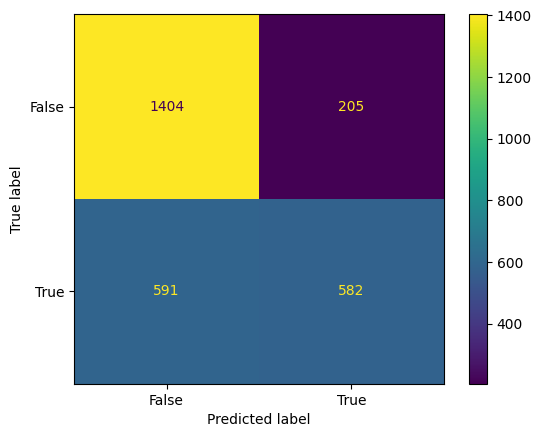

In [86]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_upsampled_valid,tree_prediction_balanced))
confusion_matrix = metrics.confusion_matrix(target_upsampled_valid,tree_prediction_balanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

En cuanto a nuestras métricas de recall y f1 score, pasamos de un 0.28 y 0.41 respectivamente, a 0.50 y 0.59, lo que nos indica que el sobremuestreo de nuestros datos mejoró estas métricas.

### Logistic Regression con sobremuestreo

In [87]:
log_random.fit(features_upsampled_train,target_upsampled_train)
print(log_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'warm_start': False, 'solver': 'liblinear', 'max_iter': 266, 'C': 0.060000000000000005}


In [88]:
#Medimos la exactitud del modelo
best_log_balanced = log_random.best_estimator_
log_prediction_balanced = best_log_balanced.predict(features_upsampled_valid)
log_accuracy_balanced=metrics.accuracy_score(target_upsampled_valid,log_prediction_balanced)
roc_auc_lrb=roc_auc_score(target_upsampled_valid,log_prediction_balanced)
print("Accuracy:",log_accuracy_balanced)
print('ROC-AUC: ',roc_auc_lr)
print('Diferencia accuracy: ',log_accuracy_balanced-log_accuracy)
print('Diferencia ROC-AUC: ',roc_auc_lrb-roc_auc_lr)
recall_lrb=metrics.recall_score(target_upsampled_valid,log_prediction_balanced)
f1_lrb=metrics.f1_score(target_upsampled_valid,log_prediction_balanced)
print('Recall: ',recall_lrb,'\nF1-score: ',f1_lrb)
print('Diferencia Recall: ',recall_lrb-recall_lr)
print('Diferencia F1: ',f1_lrb-f1_lr)

Accuracy: 0.703450754852624
ROC-AUC:  0.5726619288242765
Diferencia accuracy:  -0.11204924514737602
Diferencia ROC-AUC:  0.11379246215739791
Recall:  0.578005115089514 
F1-score:  0.6217331499312242
Diferencia Recall:  0.40409207161125316
Diferencia F1:  0.3524262192381549


Al ver el cambio de la exactitud, podemos ver que el sobreajuste disminuye en un 11%, sin embargo, la calidad de nuestro modelo aumento con la ROC-AUC en un 11%.

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      1609
           1       0.67      0.58      0.62      1173

    accuracy                           0.70      2782
   macro avg       0.70      0.69      0.69      2782
weighted avg       0.70      0.70      0.70      2782



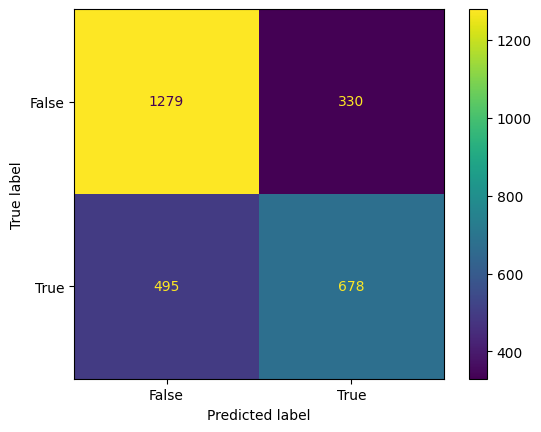

In [89]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_upsampled_valid,log_prediction_balanced))
confusion_matrix = metrics.confusion_matrix(target_upsampled_valid,log_prediction_balanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Al ver nuestras otras métricas, el sobre ajuste cambió el recall y el f1 score respectivamente de 0.17 y 0.27 a 0.58 y 0.62, lo que es un cambio gigantezco en mejora de éstas métricas, lo que nos indica que el sobreajuste mejoro mucho muestro modelo de regresión logística.

### Submuestreo

In [90]:
#Definimos la función para reducir el tamaño de la clase predominante y submuestrear los datos
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [91]:
features_downsampled_train, target_downsampled_train = downsample(
    features_upsampled_train, target_upsampled_train, 0.75
)
features_downsampled_valid, target_downsampled_valid = downsample(
    features_upsampled_valid, target_upsampled_valid, 0.75
)

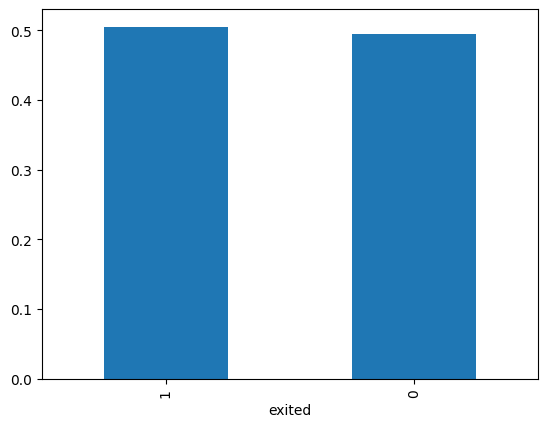

In [92]:
#Gráficamos las frecuencias relativas de cada clase
balance=target_downsampled_train.value_counts(normalize=True)
plt=balance.plot(kind='bar')

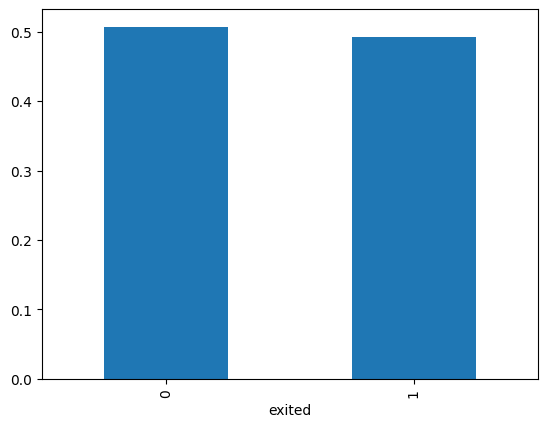

In [94]:
balance=target_downsampled_valid.value_counts(normalize=True)
plt=balance.plot(kind='bar')

### Random Forest con submuestreo

In [95]:
# Entrenamos el modelo de nuevo con sobremuestreo
model_random.fit(features_downsampled_train,target_downsampled_train)
print(model_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': False, 'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1800}


In [ ]:
#Medimos la exactitud de nuestro modelo 
best_random = model_random.best_estimator_
random_prediction_subbalanced = best_random.predict(features_downsampled_valid)
random_accuracy_subbalanced=metrics.accuracy_score(target_downsampled_valid,random_prediction_subbalanced)
roc_auc_rfs=roc_auc_score(target_downsampled_valid,random_prediction_subbalanced)
print("Accuracy:",random_accuracy_subbalanced)
print('ROC-AUC: ',roc_auc_rfs)
print('Diferencia accuracy: ',random_accuracy_subbalanced-random_accuracy_balanced)
print('Diferencia ROC-AUC: ',roc_auc_rfs-roc_auc_rfb)
recall_rfs=metrics.recall_score(target_downsampled_valid,random_prediction_subbalanced)
f1_rfs=metrics.f1_score(target_downsampled_valid,random_prediction_subbalanced)
print('Recall: ',recall_rfs,'\nF1-score: ',f1_rfs)
print('Diferencia Recall: ',recall_rfs-recall_rfb)
print('Diferencia F1: ',f1_rfs-f1_rfb)

Accuracy: 0.7357142857142858
ROC-AUC:  0.7327725946471669
Diferencia accuracy:  -0.009792543904693418
Diferencia ROC-AUC:  0.026593000643488685
Recall:  0.5268542199488491 
F1-score:  0.6627345844504021
Diferencia Recall:  0.0716112531969309
Diferencia F1:  0.061383233099050805


La exactitud del modelo submuestreado al igual que en el sobremuestreo disminuye, teniendo en cuenta el modelos sobremuestreado, nuestra exactitud disminuye de nuevo en un 0.09%, sin embargo, nuestra curva ROC-AUC aumenta su calidad en un 2.6%.

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1207
           1       0.89      0.53      0.66      1173

    accuracy                           0.74      2380
   macro avg       0.78      0.73      0.72      2380
weighted avg       0.78      0.74      0.72      2380



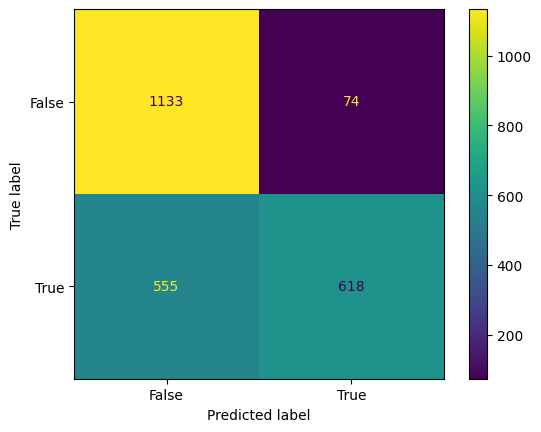

In [ ]:
#Mostramos la matriz de confusión y el reporte con nuestras métricas de clasificación
print(classification_report(target_downsampled_valid,random_prediction_subbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_valid,random_prediction_subbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Nuevamente, aumentamos nuestras métricas de recall y f1 score, de 0.48, 0.62 a 0.52 y 0.66, lo que nos indica que nuestro submuestreo también mejoró estas métricas con respecto a nuestro dataset sobremuestreado.

### Decision Tree con submuestreo

In [ ]:
random_tree.fit(features_downsampled_train,target_downsampled_train)
print(random_tree.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1}


In [ ]:
#Medimos la exactitud del modelo
best_tree_subbalanced = random_tree.best_estimator_
tree_prediction_subbalanced = best_tree_subbalanced.predict(features_downsampled_valid)
tree_accuracy_subbalanced=metrics.accuracy_score(target_downsampled_valid,tree_prediction_subbalanced)
roc_auc_dts=roc_auc_score(target_downsampled_valid,tree_prediction_subbalanced)
print("Accuracy:",tree_accuracy_subbalanced)
print('ROC-AUC: ',roc_auc_dts)
print('Diferencia accuracy: ',tree_accuracy_subbalanced-tree_accuracy_balanced)
print('Diferencia ROC-AUC: ',roc_auc_dts-roc_auc_dtb)
recall_dts=metrics.recall_score(target_downsampled_valid,tree_prediction_subbalanced)
f1_dts=metrics.f1_score(target_downsampled_valid,tree_prediction_subbalanced)
print('Recall: ',recall_dts,'\nF1-score: ',f1_dts)
print('Diferencia Recall: ',recall_dts-recall_dtb)
print('Diferencia F1: ',f1_dts-f1_dtb)

Accuracy: 0.7088235294117647
ROC-AUC:  0.7067648859911387
Diferencia accuracy:  -0.006489195246754287
Diferencia ROC-AUC:  0.02079768423757533
Recall:  0.5626598465473146 
F1-score:  0.6557377049180328
Diferencia Recall:  0.06393861892583125
Diferencia F1:  0.05940742968867507


La exactitud aumenta en este caso un porcentaje muy mínimo, y nuestra calidad del modelo aumenta en un 2.7% la curva ROC-AUC, lo que indica que el submuestreo mejoró nuestro modelo con el dataset ya sobremuestreado.

              precision    recall  f1-score   support

           0       0.67      0.85      0.75      1207
           1       0.79      0.56      0.66      1173

    accuracy                           0.71      2380
   macro avg       0.73      0.71      0.70      2380
weighted avg       0.73      0.71      0.70      2380



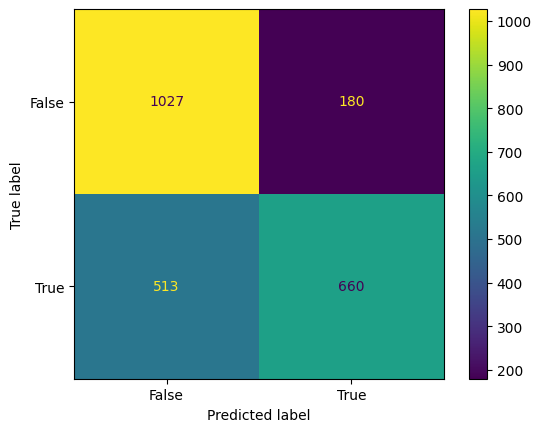

In [ ]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_downsampled_valid,tree_prediction_subbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_valid,tree_prediction_subbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Nuesto submuestreo, aumento el recall y el f1 score de nuestro modelo de 0.50 y 0.59 a 0.56 y 0.65, lo que mejora la calidad de nuestro arbol de decición.

### Logistic Regression con submuestreo

In [ ]:
log_random.fit(features_downsampled_train,target_downsampled_train)
print(log_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'warm_start': False, 'solver': 'lbfgs', 'max_iter': 285, 'C': 0.02}


In [ ]:
#Medimos la exactitud del modelo
best_log_subbalanced = log_random.best_estimator_
log_prediction_subbalanced = best_log_subbalanced.predict(features_downsampled_valid)
log_accuracy_subbalanced=metrics.accuracy_score(target_downsampled_valid,log_prediction_subbalanced)
roc_auc_lrs=roc_auc_score(target_downsampled_valid,log_prediction_subbalanced)
print("Accuracy:",log_accuracy_subbalanced)
print('ROC-AUC: ',roc_auc_lrs)
print('Diferencia accuracy: ',log_accuracy_subbalanced-log_accuracy_balanced)
print('Diferencia ROC-AUC: ',roc_auc_lrs-roc_auc_lrb)
recall_lrs=metrics.recall_score(target_downsampled_valid,log_prediction_subbalanced)
f1_lrs=metrics.f1_score(target_downsampled_valid,log_prediction_subbalanced)
print('Recall: ',recall_lrs,'\nF1-score: ',f1_lrs)
print('Diferencia Recall: ',recall_lrs-recall_lrb)
print('Diferencia F1: ',f1_lrs-f1_lrb)

Accuracy: 0.6987394957983193
ROC-AUC:  0.6986239688772019
Diferencia accuracy:  -0.005070712684786427
Diferencia ROC-AUC:  0.011858825875639467
Recall:  0.690537084398977 
F1-score:  0.693196405648267
Diferencia Recall:  0.11253196930946296
Diferencia F1:  0.07117805702441382


Aunque la exactitud disminuye un porcentaje muy mínimo, casi descartable, nuestra ROC-AUC, aumenta en un 1.1%, lo que nos muestra que el submuestreo mejoró nuestro modelo ligeramente.

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1207
           1       0.70      0.69      0.69      1173

    accuracy                           0.70      2380
   macro avg       0.70      0.70      0.70      2380
weighted avg       0.70      0.70      0.70      2380



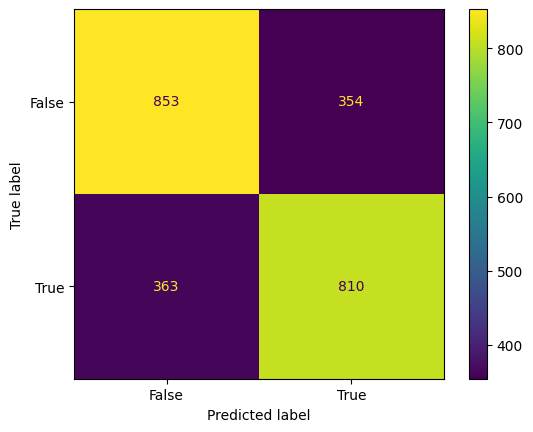

In [ ]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_downsampled_valid,log_prediction_subbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_valid,log_prediction_subbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

El recall y el f1 score aumentaron de 0.58 y 0.62 respectivamente a 0.69 y 0.69, lo que nos muestra que el submuestreo mejoró significativamente nuestra regresión logística.

## Prueba Final

In [ ]:
features_test= df_test.drop(['exited'],axis=1)
target_test=df_test['exited']

In [ ]:
features_upsampled_test, target_upsampled_test = upsample(
    features_test, target_test, 3
)
features_downsampled_test, target_downsampled_test = downsample(
    features_upsampled_test, target_upsampled_test, 0.75
)

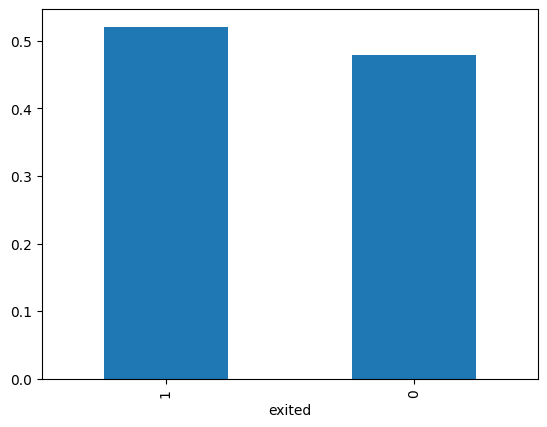

In [ ]:
#Gráficamos las frecuencias relativas de cada clase
balance=target_downsampled_test.value_counts(normalize=True)
plt=balance.plot(kind='bar')

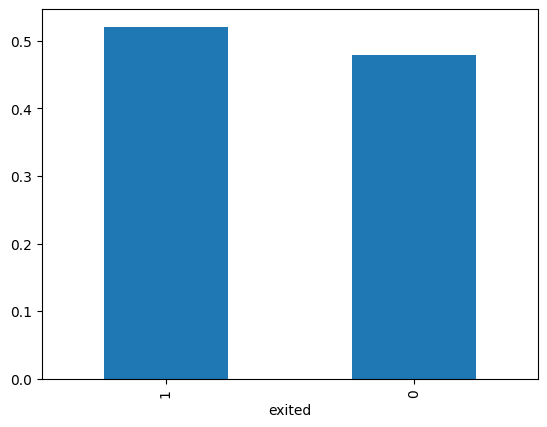

In [ ]:
#Gráficamos las frecuencias relativas de cada clase
balance=target_downsampled_test.value_counts(normalize=True)
plt=balance.plot(kind='bar')

### Random Forest prueba final

In [ ]:
#Medimos la exactitud de nuestro modelo 
best_random = model_random.best_estimator_
random_prediction_finalbalanced = best_random.predict(features_downsampled_test)
random_accuracy_finalbalanced=metrics.accuracy_score(target_downsampled_test,random_prediction_finalbalanced)
print("Accuracy:",random_accuracy_finalbalanced)
print('ROC-AUC: ',roc_auc_score(target_downsampled_test,random_prediction_finalbalanced))

Accuracy: 0.7188134904510362
ROC-AUC:  0.7272258166951135


              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1180
           1       0.89      0.52      0.66      1281

    accuracy                           0.72      2461
   macro avg       0.77      0.73      0.71      2461
weighted avg       0.77      0.72      0.71      2461



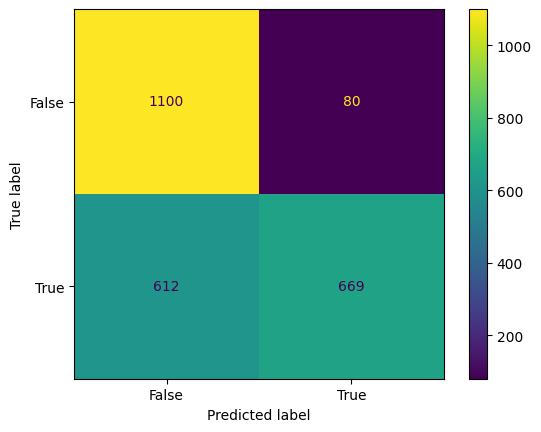

In [ ]:
#Mostramos la matriz de confusión y el reporte con nuestras métricas de clasificación
print(classification_report(target_downsampled_test,random_prediction_finalbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_test,random_prediction_finalbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Al probar el mejor random forest y balanceando los datos del grupo test con nuestras dos técnicas de sobremuestreo y submuestreo, obtenemos lo siguiente: La exactitud del modelo fue del 72% y la curva ROC-AUC del 73%, Adicionalmente nuestro recall fue de 0.53 y el f1 score de 0.66. 

Si hacemos un recuento de estos resultados, el modelo pasa con una exactitud un poco baja debido a las técnicas de balanceo, sin embargo, tiene una mejor calidad que el dataset desbalanceado que era de ROC-AUC 70%. Esto quiere decir que en general nuestro modelo mejoró al aplicar las técnicas de balanceo.

### Decision Tree prueba final

In [ ]:
#Medimos la exactitud del modelo
best_tree_finalbalanced = random_tree.best_estimator_
tree_prediction_finalbalanced = best_tree_finalbalanced.predict(features_downsampled_test)
tree_accuracy_finalbalanced=metrics.accuracy_score(target_downsampled_test,tree_prediction_finalbalanced)
print("Accuracy:",tree_accuracy_finalbalanced)
print('ROC-AUC: ',roc_auc_score(target_downsampled_test,tree_prediction_finalbalanced))

Accuracy: 0.6834620073141
ROC-AUC:  0.6903614099154528


              precision    recall  f1-score   support

           0       0.62      0.86      0.72      1180
           1       0.80      0.52      0.63      1281

    accuracy                           0.68      2461
   macro avg       0.71      0.69      0.68      2461
weighted avg       0.72      0.68      0.68      2461



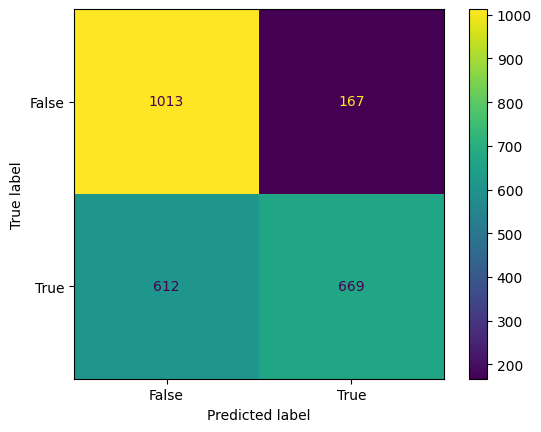

In [ ]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_downsampled_test,tree_prediction_finalbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_test,tree_prediction_finalbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Al probar el arbol de decisión y balanceando los datos del grupo test con nuestras dos técnicas de sobremuestreo y submuestreo, obtenemos lo siguiente: La exactitud del modelo fue del 67% y la curva ROC-AUC del 67%, Adicionalmente nuestro recall fue de 0.48 y el f1 score de 0.60. 

Si hacemos un recuento de estos resultados, el modelo pasa con una exactitud un poco baja debido a las técnicas de balanceo, además bajó la calidad con respecto al dataset desbalanceado que era de ROC-AUC 70%. Esto quiere decir que en general nuestro modelo empeoró al aplicar las técnicas de balanceo, quizas porque el modelo es muy sensible al modificar los datos con las técnicas de balanceo. De todas maneras se cumplió dejando el f1 score alto.

### Logistic Regression prueba final

In [ ]:
#Medimos la exactitud del modelo
best_log_finalbalanced = log_random.best_estimator_
log_prediction_finalbalanced = best_log_finalbalanced.predict(features_downsampled_test)
log_accuracy_finalbalanced=metrics.accuracy_score(target_downsampled_test,log_prediction_finalbalanced)
print("Accuracy:",log_accuracy_finalbalanced)
print('ROC-AUC: ',roc_auc_score(target_downsampled_test,log_prediction_finalbalanced))

Accuracy: 0.7021535960991467
ROC-AUC:  0.7020352875798834


              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1180
           1       0.72      0.70      0.71      1281

    accuracy                           0.70      2461
   macro avg       0.70      0.70      0.70      2461
weighted avg       0.70      0.70      0.70      2461



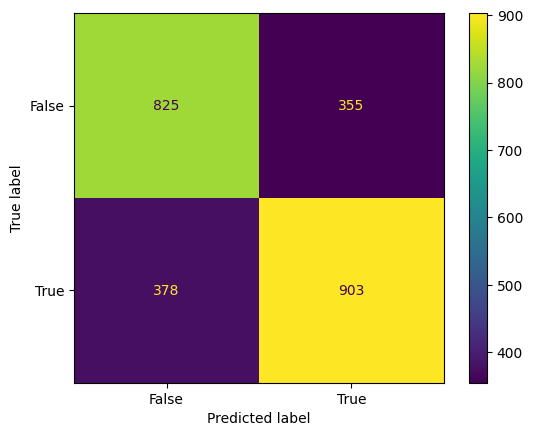

In [ ]:
#Mostramos la matriz de confusión y el reporte de métricas de clasificación
print(classification_report(target_downsampled_test,log_prediction_finalbalanced))
confusion_matrix = metrics.confusion_matrix(target_downsampled_test,log_prediction_finalbalanced)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

plt=cm_display.plot()

Por último, la regresión logística y balanceando los datos del grupo test con nuestras dos técnicas de sobremuestreo y submuestreo, 0.70 y el f1 score de 0.71. 

Si hacemos un recuento de estos resultados, el modelo pasa con una exactitud un poco baja debido a las técnicas de balanceo, además bajó la calidad con respecto al dataset desbalanceado que era de ROC-AUC 57%. Esto quiere decir que este modelo fue el más beneficiado por el balanceo, debido a que su calidad aumento mucho.

## Conclusiones

1. El balanceo mejora la calidad de los modelos de clasificación teniendo en cuenta la curva ROC-AUC, su f1-score y su recall, sin embargo, al aplicar las técicas de sobremuestreo y submuestreo, la exactitud de nuestros modelos baja significativamente.

2. El mejor modelo evaluado fue el random forest que tuvo una métrica de ROC-AUC del 72%, seguido de la regresión logística con 70% y el arbol de decisión con un 69%.

3. El arbol de decisión fue sensible a las técnicas de balanceo, por lo tanto, se vio afectada su métrica ROC-AUC y empeoró con respecto al dataset sin balancear, aunque sus métricas de recall y f1-score aumentaron.